In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os

# Set dataset path for Autistic Children Emotions dataset
base_dir = 'dataset2/Autism emotion recogition dataset/Autism emotion recogition dataset/'

# Subdirectories (note capitalized Train/Test)
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')

print("🔄 Using Autistic Children Emotions Dataset")
print(f"📁 Dataset path: {base_dir}")

# Emotion classes for Autistic Children Emotions dataset (6 classes)
categories = ['anger', 'fear', 'joy', 'Natural', 'sadness', 'surprise']

print("📊 Emotion classes: anger, fear, joy, Natural, sadness, surprise")

# Function to count images in each category
def count_images(directory):
    counts = {}
    total = 0
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.exists(category_path):
            count = len([f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
            counts[category] = count
            total += count
        else:
            counts[category] = 0
    return counts, total

# Print detailed image counts with analysis
print("\n" + "="*60)
print("AUTISTIC CHILDREN EMOTIONS DATASET ANALYSIS")
print("="*60)

train_counts, train_total = count_images(train_dir)
test_counts, test_total = count_images(test_dir)

print(f"\n📈 Training Set ({train_total} total images):")
for category, count in train_counts.items():
    percentage = (count / train_total * 100) if train_total > 0 else 0
    print(f"   {category:<10}: {count:>4} images ({percentage:>5.1f}%)")

print(f"\n📊 Test Set ({test_total} total images):")
for category, count in test_counts.items():
    percentage = (count / test_total * 100) if test_total > 0 else 0
    print(f"   {category:<10}: {count:>4} images ({percentage:>5.1f}%)")



🔄 Using Autistic Children Emotions Dataset
📁 Dataset path: dataset2/Autism emotion recogition dataset/Autism emotion recogition dataset/
📊 Emotion classes: anger, fear, joy, Natural, sadness, surprise

AUTISTIC CHILDREN EMOTIONS DATASET ANALYSIS

📈 Training Set (1171 total images):
   anger     :  196 images ( 16.7%)
   fear      :  195 images ( 16.7%)
   joy       :  197 images ( 16.8%)
   Natural   :  197 images ( 16.8%)
   sadness   :  190 images ( 16.2%)
   surprise  :  196 images ( 16.7%)

📊 Test Set (226 total images):
   anger     :   40 images ( 17.7%)
   fear      :   36 images ( 15.9%)
   joy       :   35 images ( 15.5%)
   Natural   :   40 images ( 17.7%)
   sadness   :   38 images ( 16.8%)
   surprise  :   37 images ( 16.4%)


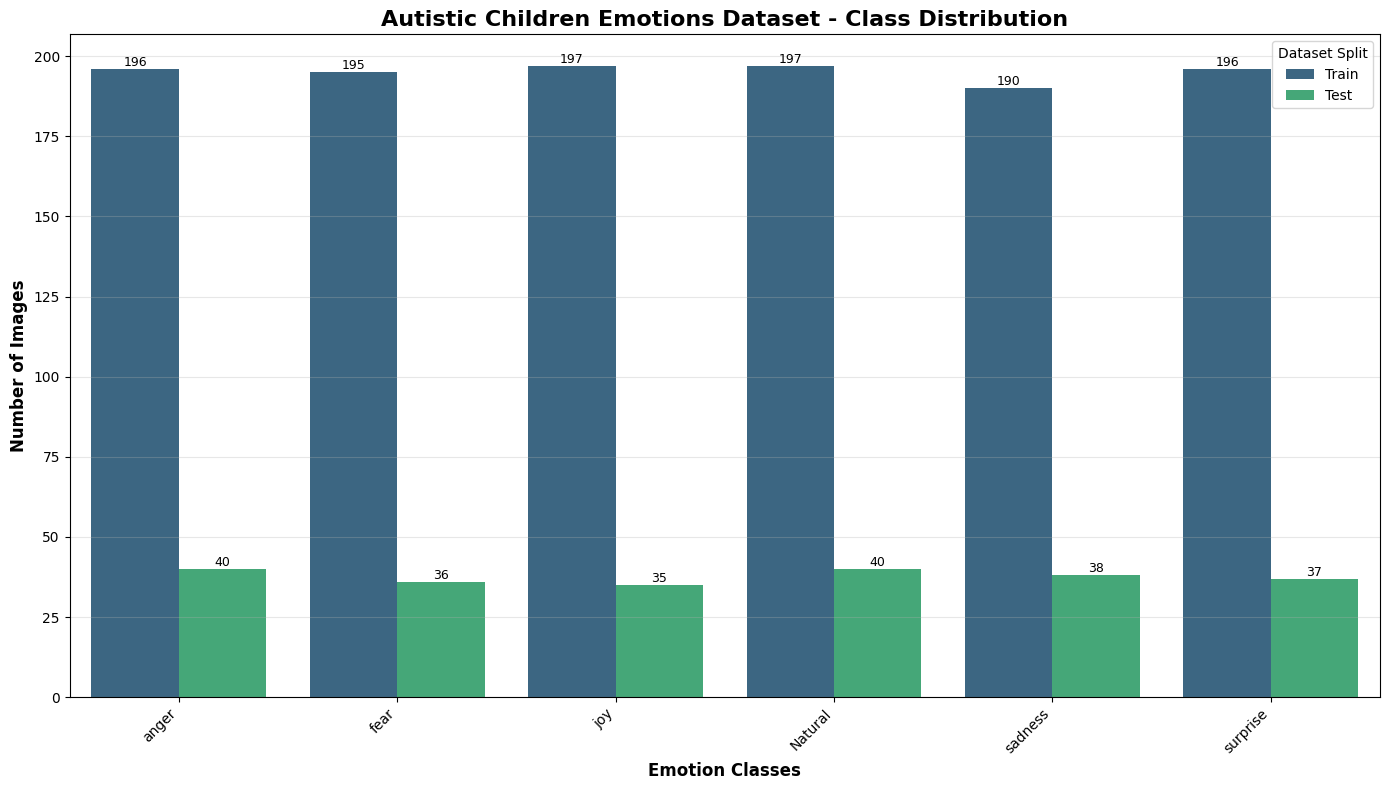


📊 Dataset Summary:
Total Training Images: 1171
Total Test Images: 226
Total Images: 1397
Number of Classes: 6
Classes: Natural, anger, fear, joy, sadness, surprise


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

# Create a DataFrame for visualization
data = []
for dataset_name, dataset_dir in [('Train', train_dir), ('Test', test_dir)]:
    counts, total = count_images(dataset_dir)  # Unpack the tuple
    for emotion, count in counts.items():
        data.append({'Dataset': dataset_name, 'Emotion': emotion, 'Count': count})

df = pd.DataFrame(data)

# Plot using Seaborn with proper DataFrame structure
plt.figure(figsize=(14, 8))
sn.barplot(data=df, x='Emotion', y='Count', hue='Dataset', palette='viridis')
plt.title('Autistic Children Emotions Dataset - Class Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Emotion Classes', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset Split', fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Add value labels on bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', fontsize=9)

plt.show()

# Display summary statistics
print(f"\n📊 Dataset Summary:")
print(f"Total Training Images: {df[df['Dataset'] == 'Train']['Count'].sum()}")
print(f"Total Test Images: {df[df['Dataset'] == 'Test']['Count'].sum()}")
print(f"Total Images: {df['Count'].sum()}")
print(f"Number of Classes: {len(df['Emotion'].unique())}")
print(f"Classes: {', '.join(sorted(df['Emotion'].unique()))}")

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 200
BATCH_SIZE = 32

print("🔄 Setting up data generators for Autistic Children Emotions dataset")
print(f"📐 Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"📦 Batch size: {BATCH_SIZE}")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of training data for validation
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

print("✅ Data generators created with augmentation for training set")

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

print("\n📊 Data generators summary:")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {val_generator.samples}")
print(f"   Test samples: {test_generator.samples}")
print(f"   Number of classes: {len(train_generator.class_indices)}")
print(f"   Classes: {list(train_generator.class_indices.keys())}")


🔄 Setting up data generators for Autistic Children Emotions dataset
📐 Image size: 200x200
📦 Batch size: 32
✅ Data generators created with augmentation for training set
Found 938 images belonging to 6 classes.
Found 233 images belonging to 6 classes.
Found 226 images belonging to 6 classes.

📊 Data generators summary:
   Training samples: 938
   Validation samples: 233
   Test samples: 226
   Number of classes: 6
   Classes: ['Natural', 'anger', 'fear', 'joy', 'sadness', 'surprise']


📸 Displaying sample augmented images from training set
   Batch shape: (32, 200, 200, 3)
   Number of images: 32
   Image shape: (200, 200, 3)


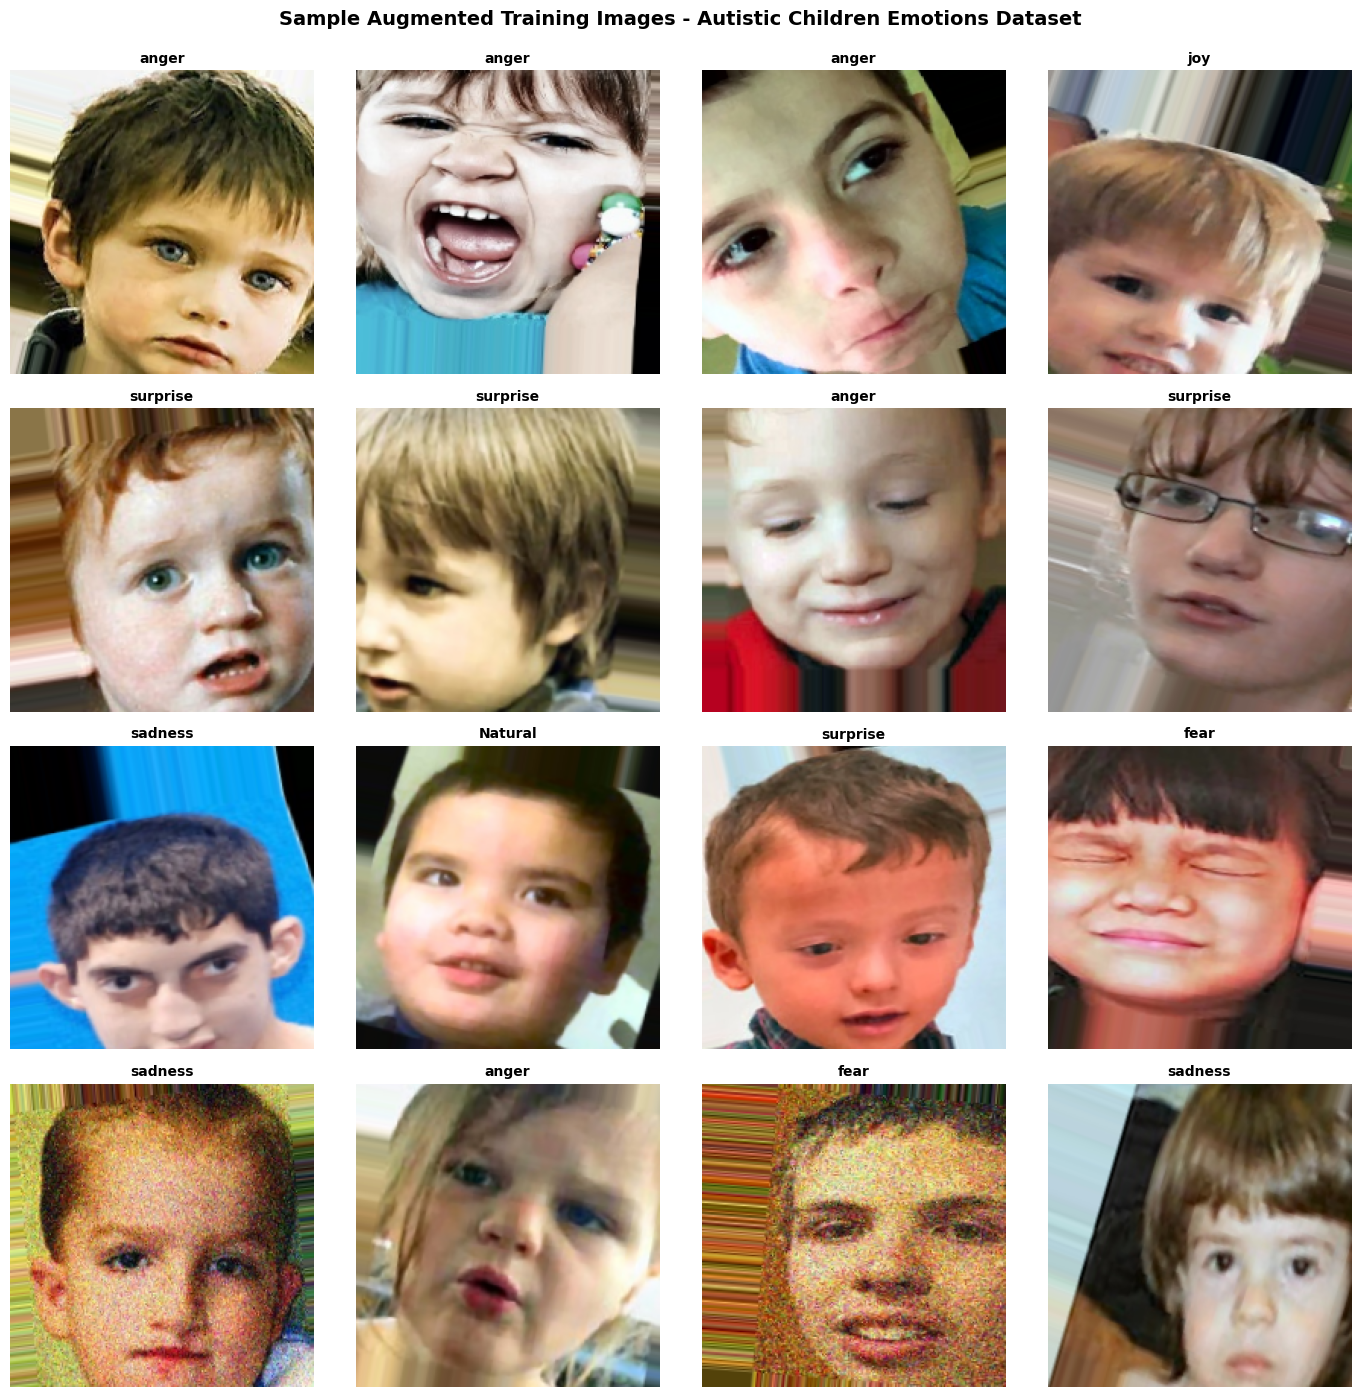


✅ Displayed 16 sample images with data augmentation
   Classes shown: {'anger', 'fear', 'Natural', 'sadness', 'joy', 'surprise'}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Calculate class weights to handle imbalanced dataset
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

print("\n" + "="*70)
print("⚖️  CLASS WEIGHTS FOR BALANCING")
print("="*70)
for class_idx, weight in class_weight_dict.items():
    class_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(class_idx)]
    print(f"Class {class_idx} ({class_name}): {weight:.4f}")
print("="*70)
# Get a batch of augmented images
aug_images, aug_labels = next(train_generator)

print(f"📸 Displaying sample augmented images from training set")
print(f"   Batch shape: {aug_images.shape}")
print(f"   Number of images: {len(aug_images)}")
print(f"   Image shape: {aug_images[0].shape}")

# Plot - Note: images are RGB (3 channels), not grayscale
plt.figure(figsize=(14, 14))
num_images = min(16, len(aug_images))  # Show up to 16 images

for i in range(num_images):
    plt.subplot(4, 4, i + 1)
    # Images are RGB, so no need for cmap='gray' and no squeeze needed
    plt.imshow(aug_images[i])
    # Get the class name from the label
    class_idx = np.argmax(aug_labels[i])
    class_names = list(train_generator.class_indices.keys())
    class_name = class_names[class_idx]
    plt.title(f"{class_name}", fontsize=10, fontweight='bold')
    plt.axis('off')

plt.suptitle('Sample Augmented Training Images - Autistic Children Emotions Dataset', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\n✅ Displayed {num_images} sample images with data augmentation")
print(f"   Classes shown: {set([list(train_generator.class_indices.keys())[np.argmax(aug_labels[i])] for i in range(num_images)])}")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import AdamW

IMG_SIZE = 200
NUM_CLASSES = 6  # Updated for Autistic Children Emotions dataset (6 emotion classes)

print(f"🎯 Model configured for {NUM_CLASSES} emotion classes")
print("📊 Classes: anger, fear, joy, Natural, sadness, surprise")

# Load Xception base model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze layers
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Create the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    # Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    # Dropout(0.5),
    # Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    # Dropout(0.6),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-4), # Example AdamW
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_xception_autistic_emotions.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Summary
model.summary()

I0000 00:00:1745170933.175592      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745170933.176271      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,655 (80.58 MB)

 Trainable params: 9,203,527 (35.11 MB)

 Non-trainable params: 11,921,128 (45.48 MB)

In [ ]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=16,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weight_dict
)

In [ ]:

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\n Test Accuracy: {test_acc:.4f}")
print(f" Test Loss: {test_loss:.4f}")

3589/3589 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.9521 - loss: 1.0967

 Test Accuracy: 0.9521
 Test Loss: 0.9799


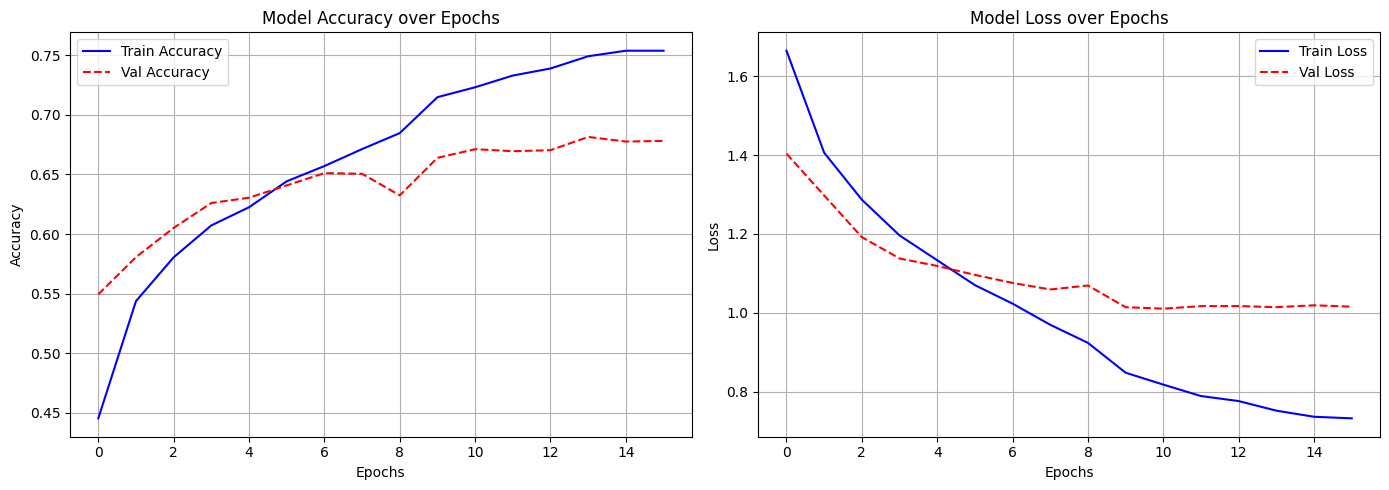

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plot training and validation accuracy/loss
history = fine_tune_history.history

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], 'b',label='Train Accuracy')
plt.plot(history['val_accuracy'], 'r--',label='Val Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history['loss'], 'b' , label='Train Loss')
plt.plot(history['val_loss'], 'r--',label='Val Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Per-class Metrics:
     anger - Precision: 1.00, Recall: 0.95, F1: 0.97, Support: 40
      fear - Precision: 0.97, Recall: 0.94, F1: 0.96, Support: 36
       joy - Precision: 0.94, Recall: 0.94, F1: 0.94, Support: 35
   Natural - Precision: 0.93, Recall: 0.97, F1: 0.95, Support: 40
   sadness - Precision: 0.97, Recall: 0.95, F1: 0.96, Support: 38
  surprise - Precision: 0.90, Recall: 0.95, F1: 0.92, Support: 37

Overall Accuracy: 0.9513 (95.13%)

Classification Report:
              precision    recall  f1-score   support

       anger       1.00      0.95      0.97        40
        fear       0.97      0.94      0.96        36
         joy       0.94      0.94      0.94        35
     Natural       0.93      0.97      0.95        40
     sadness       0.97      0.95      0.96        38
    surprise       0.90      0.95      0.92        37

    accuracy                           0.95       226
   macro avg       0.95      0.95      0.95       226
weighted avg       0.95      0.95     

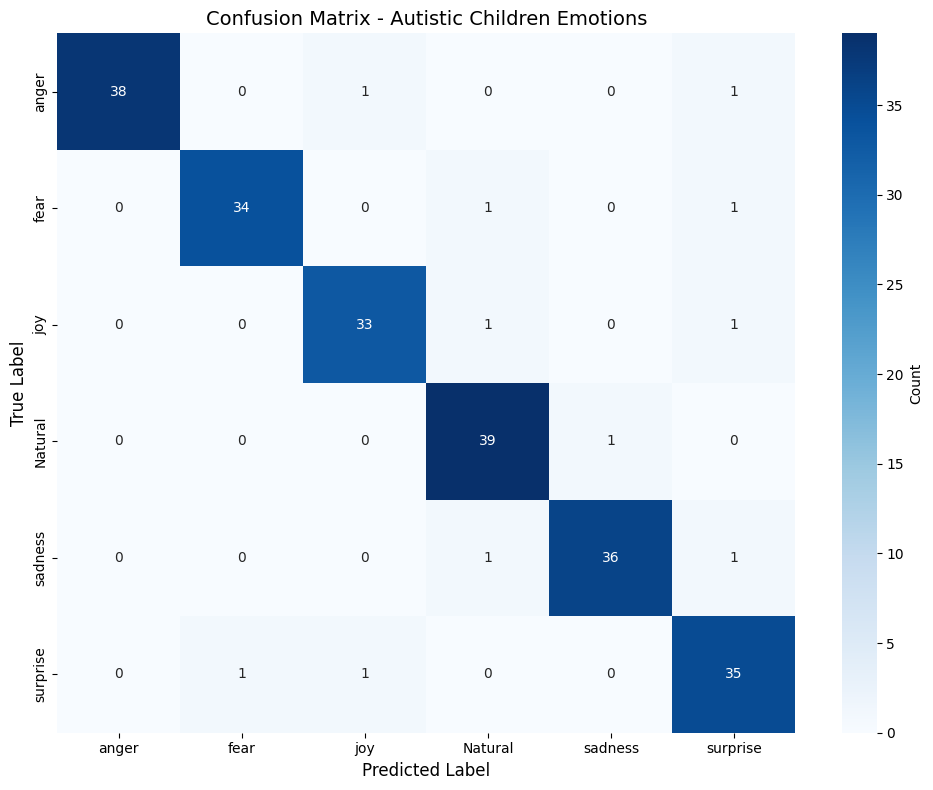

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n")
print(report)